### Características

    RowNumber: índice de cadena de datos
    CustomerId: identificador de cliente único
    Surname: apellido
    CreditScore: valor de crédito
    Geography: país de residencia
    Gender: sexo
    Age: edad
    Tenure: período durante el cual ha madurado el depósito a plazo fijo de un cliente (años)
    Balance: saldo de la cuenta
    NumOfProducts: número de productos bancarios utilizados por el cliente
    HasCrCard: el cliente tiene una tarjeta de crédito (1 - sí; 0 - no)
    IsActiveMember: actividad del cliente (1 - sí; 0 - no)
    EstimatedSalary: salario estimado
### Objetivo

    Exited: El cliente se ha ido (1 - sí; 0 - no)

In [67]:
# Importamos las librerias a utilizar
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split,  GridSearchCV, cross_val_score
from sklearn.preprocessing import  StandardScaler, minmax_scale, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBClassifier

In [68]:
# Importamos la data a analizar
data = pd.read_csv('../source/Churn.csv')
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [69]:
# Revisamos el tipo de DF
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [70]:
# Validamos cantidad de valores vacios hay en la categoria Tenure
data['Tenure'].isna().sum()

909

Podemos darnos cuenta, que en la columna Tenure, se cuenta con valores vacios, analizando el caso, se ha tomado la decicision de reemplazarlo con el valor '0', ya que son personas que no cuentan con el producto de plazo fijo, pero si otros, es por ello que son clientes del banco.

In [71]:
# Reemplazando por 0 los valores vacios
data['Tenure'] = data['Tenure'].fillna(0)
data['Tenure'] = data['Tenure'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int32  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int32(1), int64(8), object(3)
memory usage: 1.0+ MB


In [72]:
# Procedemos a eliminar columnas que no son necesarias para el modelo
data = data.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

In [73]:
data.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [74]:
data['Gender'].replace({'Female': 1,'Male': 0}, inplace=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17184\4254726997.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Gender'].replace({'Female': 1,'Male': 0}, inplace=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_17184\4254726997.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Ge

In [75]:
# Renombramos las categorias
rename = {'CreditScore': 'credit_score', 'Geography': 'geography', 'Gender':'gender', 'Age':'age', 'Tenure':'tenure', 'Balance':'balance', 'NumOfProducts':'num_of_products', 'HasCrCard': 'has_cr_card', 'IsActiveMember': 'is_active_member','EstimatedSalary':'estimated_salary', 'Exited':'exited' }
data = data.rename(columns=rename)
data

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,1,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,1,41,1,83807.86,1,0,1,112542.58,0
2,502,France,1,42,8,159660.80,3,1,0,113931.57,1
3,699,France,1,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,1,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,0,39,5,0.00,2,1,0,96270.64,0
9996,516,France,0,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,1,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,0,42,3,75075.31,2,1,0,92888.52,1


In [76]:
print(data['geography'].value_counts())
print(data['gender'].value_counts())
print(data['tenure'].value_counts())
print(data['num_of_products'].value_counts())
print(data['has_cr_card'].value_counts())
print(data['is_active_member'].value_counts())
print(data['exited'].value_counts())

geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64
gender
0    5457
1    4543
Name: count, dtype: int64
tenure
0     1291
1      952
2      950
8      933
3      928
5      927
7      925
4      885
9      882
6      881
10     446
Name: count, dtype: int64
num_of_products
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64
has_cr_card
1    7055
0    2945
Name: count, dtype: int64
is_active_member
1    5151
0    4849
Name: count, dtype: int64
exited
0    7963
1    2037
Name: count, dtype: int64


In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  int64  
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int32  
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(2), int32(1), int64(7), object(1)
memory usage: 820.4+ KB


### Codificamos con OHE

In [78]:
# Una vez codificado, procedo a eliminar columnas que podrian sesgar mi modelo, como el indice y los ID.
data_ohe= pd.get_dummies(data, drop_first=True)
data_ohe

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain
0,619,1,42,2,0.00,1,1,1,101348.88,1,False,False
1,608,1,41,1,83807.86,1,0,1,112542.58,0,False,True
2,502,1,42,8,159660.80,3,1,0,113931.57,1,False,False
3,699,1,39,1,0.00,2,0,0,93826.63,0,False,False
4,850,1,43,2,125510.82,1,1,1,79084.10,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0,39,5,0.00,2,1,0,96270.64,0,False,False
9996,516,0,35,10,57369.61,1,1,1,101699.77,0,False,False
9997,709,1,36,7,0.00,1,0,1,42085.58,1,False,False
9998,772,0,42,3,75075.31,2,1,0,92888.52,1,True,False


In [79]:
data['exited'].value_counts(normalize=True)

exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

In [80]:
# Procedo a particionar mi caracteristicas y mi objetivo.
feature = data_ohe.drop(columns='exited')
target = data_ohe['exited']

In [81]:
# Escalamos mis variables numericas.
numeric = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']
scaler = MinMaxScaler()
scaler.fit(data_ohe[numeric])
data_ohe[numeric] = scaler.transform(data_ohe[numeric])
data_ohe

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain
0,0.538,1,0.324324,0.2,0.000000,1,1,1,0.506735,1,False,False
1,0.516,1,0.310811,0.1,0.334031,1,0,1,0.562709,0,False,True
2,0.304,1,0.324324,0.8,0.636357,3,1,0,0.569654,1,False,False
3,0.698,1,0.283784,0.1,0.000000,2,0,0,0.469120,0,False,False
4,1.000,1,0.337838,0.2,0.500246,1,1,1,0.395400,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.842,0,0.283784,0.5,0.000000,2,1,0,0.481341,0,False,False
9996,0.332,0,0.229730,1.0,0.228657,1,1,1,0.508490,0,False,False
9997,0.718,1,0.243243,0.7,0.000000,1,0,1,0.210390,1,False,False
9998,0.844,0,0.324324,0.3,0.299226,2,1,0,0.464429,1,True,False


In [82]:
# Particionamos en entrenamiento y validación.
feature_train, feature_test, target_train, target_test = train_test_split(feature, target, test_size=0.30, random_state=123)
print(feature_train.shape)
print(feature_test.shape)
print(target_train.shape)
print(target_test.shape)

(7000, 11)
(3000, 11)
(7000,)
(3000,)


In [84]:
# Creacion de una funcion para la evaluacion de los modelos

def evaluacion_de_modelo(modelo, feature_train, target_train, feature_test, target_test, nombre_modelo = 'Modelo'):
    # Entrenamiento
    modelo.fit(feature_train, target_train)

    # Predicciones
    prediccion = modelo.predict(feature_test)
    prediccion_proba = modelo.predict_proba(feature_test)[:,1]

    # Metricas
    auc = roc_auc_score(target_test, prediccion_proba)
    acc = accuracy_score(target_test, prediccion)

    print(f'\n Evaluando: {nombre_modelo}')
    print(f'AUC-ROC: {auc:.4f}')
    print(f'Exactitud: {acc:.4f}')
    print('\n Reporte de Cladificación:')
    print(classification_report(target_test, prediccion))

    # Matriz de confusion

    print('Matriz de confusión:')
    display(pd.crosstab(index=target_test, columns=prediccion, colnames=['Predicho']).style.background_gradient(cmap='Reds'))

    # Curva ROC
    fpr, tpr, _ = roc_curve(target_test, prediccion)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', color='blue')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel('Falsos positivos')
    plt.ylabel('Verdaderos positivos')
    plt.title(f'Curva ROC - {nombre_modelo}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

    return auc, acc 






 Evaluando: Logistic Regression
AUC-ROC: 0.6598
Exactitud: 0.7937

 Reporte de Cladificación:
              precision    recall  f1-score   support

           0       0.80      0.99      0.88      2395
           1       0.38      0.03      0.06       605

    accuracy                           0.79      3000
   macro avg       0.59      0.51      0.47      3000
weighted avg       0.72      0.79      0.72      3000

Matriz de confusión:


Predicho,0,1
exited,,
0,2360,35
1,584,21


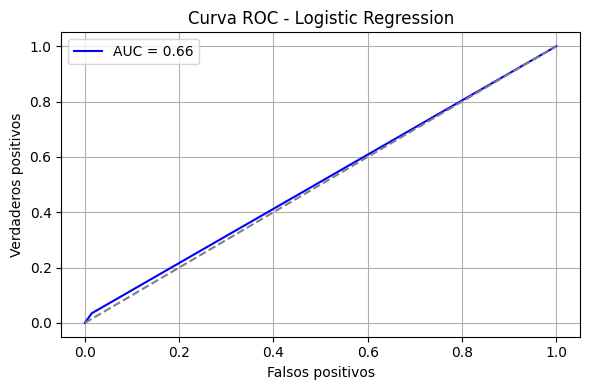

In [86]:
modelo_logreg = LogisticRegression(solver='liblinear', random_state=42)

regre_logis_auc, regre_logis_acc = evaluacion_de_modelo(modelo_logreg, feature_train, target_train, feature_test, target_test, nombre_modelo='Logistic Regression')

Nuestro modelo base, clasifica muy bien a los clientes que NO se han ido, pero, para los clientes que se han ido NO los clasifica muy bien, esto se debe a que hay un desequilibrio de clases muy notorio. Asimismo, nuestro accuracy es aceptable con un 79% de aciertos del modelo base, tomando en cuenta que esta muy sesgado es por ello que tenemos un buen accuracy.

## Procedemos a balancear las clases